In [ ]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

In [ ]:
conda install tensorflow

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: \ 

In [6]:
!pip uninstall tensorflow -y

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
EPOCHS=10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", 
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names

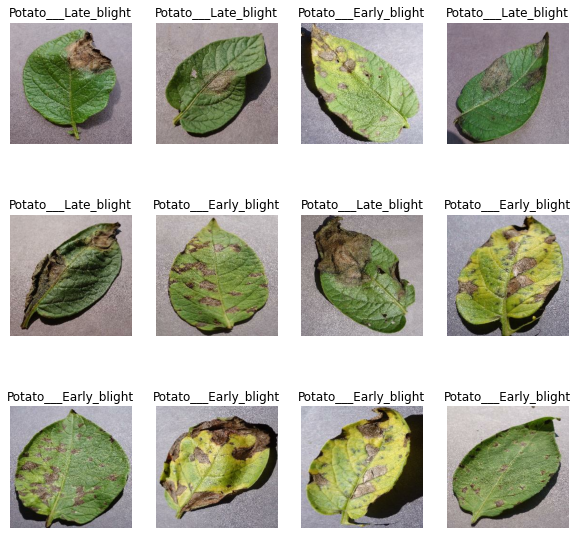

In [5]:
for image_batch, label_batch in dataset.take(1):
    plt.figure(figsize=(10,10))
    for i in range(12):
#         print(image_batch.shape)
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
#         print(label_batch.numpy())
    

In [6]:
train_size = 0.8
train_size*len(dataset)

54.400000000000006

In [7]:
train_ds = dataset.take(54)

In [8]:
tets_ds= dataset.skip(54)

In [9]:
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True,shuffle_size=10000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(len(ds)*train_split)
    train_ds = ds.take(train_size)
    temp = ds.skip(train_size)
    val_size = int(len(ds)*val_split)
    val_ds = temp.take(val_size)
    test_ds = temp.skip(val_size)
    return train_ds,val_ds,test_ds

In [10]:
train_ds,val_ds,test_ds=get_dataset_partition(dataset)

In [11]:
len(train_ds)

54

In [12]:
len(val_ds)

6

In [13]:
len(test_ds)

8

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [19]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
54/54 [==============================] - 109s 2s/step - loss: 0.8037 - accuracy: 0.5978 - val_loss: 1.4023 - val_accuracy: 0.6244
Epoch 2/10
54/54 [==============================] - 88s 2s/step - loss: 0.4688 - accuracy: 0.8328 - val_loss: 0.4275 - val_accuracy: 0.8420
Epoch 3/10
54/54 [==============================] - 88s 2s/step - loss: 0.2719 - accuracy: 0.8999 - val_loss: 0.5414 - val_accuracy: 0.8154
Epoch 4/10
54/54 [==============================] - 87s 2s/step - loss: 0.2743 - accuracy: 0.8906 - val_loss: 0.2169 - val_accuracy: 0.9155
Epoch 5/10
54/54 [==============================] - 89s 2s/step - loss: 0.2002 - accuracy: 0.9207 - val_loss: 0.1835 - val_accuracy: 0.9294
Epoch 6/10
54/54 [==============================] - 89s 2s/step - loss: 0.2268 - accuracy: 0.9155 - val_loss: 0.2568 - val_accuracy: 0.9062
Epoch 7/10
54/54 [==============================] - 87s 2s/step - loss: 0.1612 - accuracy: 0.9433 - val_loss: 0.1934 - val_accuracy: 0.9242
Epoch 8/10
54/54 [=

In [21]:
scores=model.evaluate(test_ds)

54/54 [==============================] - 17s 306ms/step - loss: 0.1161 - accuracy: 0.9566


In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

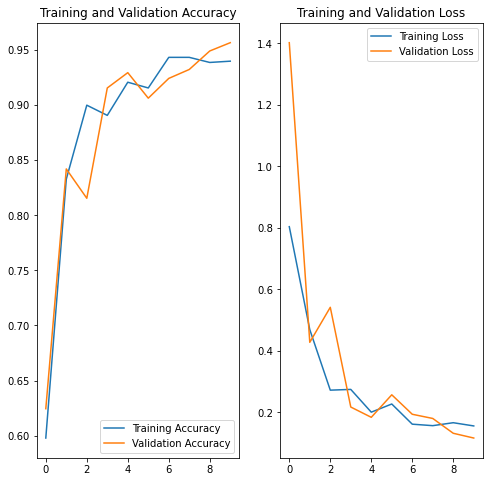

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Actual label:  Potato___Late_blight
Predicted label:  Potato___Late_blight


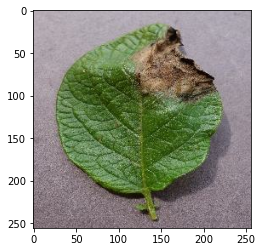

In [24]:
import numpy as np
for images_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]
    print("Actual label: ",class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("Predicted label: ",class_names[np.argmax(batch_prediction[0])])
    plt.imshow(first_image)

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

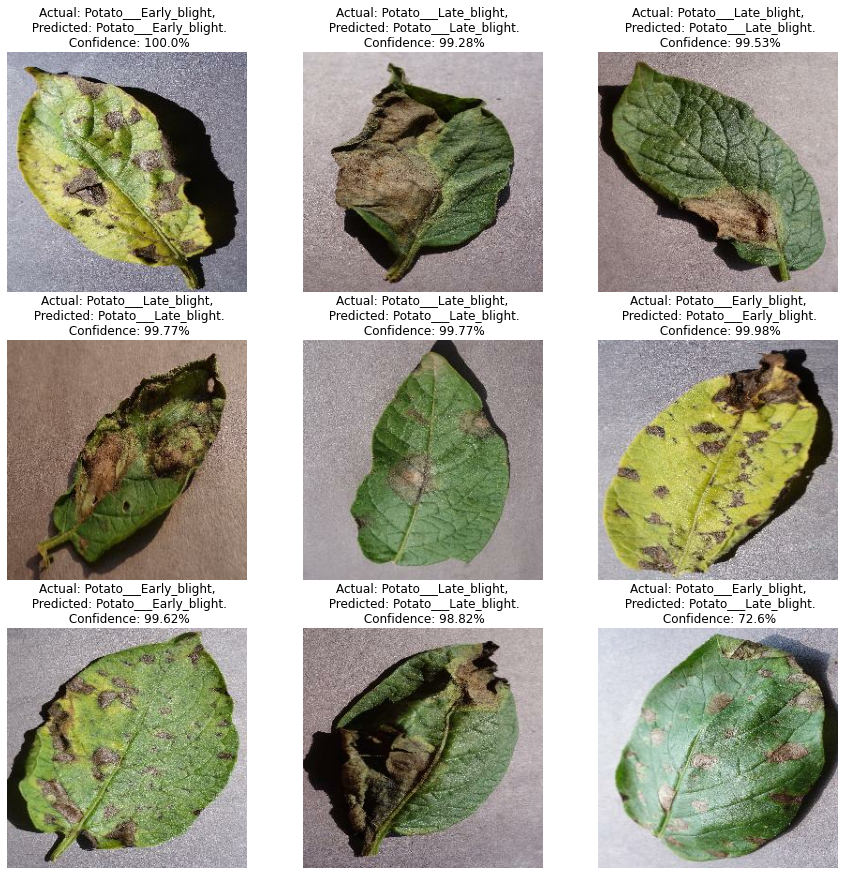

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [28]:
model.save("model_1", save_format='h5')

In [33]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}",save_format='h5')